# **LV 2: Named Entity Recognition (NER)**
---

##  **1. Uvod u Named Entity Recognition**

**Named Entity Recognition (NER)** je zadatak iz područja *obrade prirodnog jezika (NLP)* gdje se iz teksta automatski prepoznaju i označavaju entiteti poput osoba, lokacija, organizacija, datuma itd.

### Najčešće korištene kategorije entiteta:
- **PERSON** – stvarne osobe
- **ORG** – organizacije, tvrtke, institucije
- **GPE** – političke jedinice (države, gradovi)
- **LOC** – lokacije koje nisu političke
- **DATE** – datumi
- **PRODUCT** – proizvodi
- **MONEY** – novčani iznosi

NER omogućuje da iz nestrukturiranog teksta izvučemo **strukturirane informacije**, što se koristi u:
- **analizi vijesti**
- **praćenju financijskih informacija**
- **analizi društvenih mreža**
- **izradi znanstvenih i tehnoloških baza podataka**
- **chatbotovima i tražilicama**

---


## **2. Korištene biblioteke**

U ovoj vježbi koristimo:

### spaCy
Biblioteka za obradu jezika, uključuje:
- pre-trainane NLP modele
- detekciju entiteta, tokenizaciju, lematizaciju...

### pandas
Za tablični prikaz izdvojenih entiteta.

### matplotlib
Za vizualizaciju frekvencija entiteta.

---


##  **3. Inicijalizacija okruženja i osnovni primjeri**

---



In [ ]:
import spacy
from spacy.tokens import Span
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 51.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Primjer: *Osnovni NER u spaCy*
---
Demonstracija kako spaCy prepoznaje entitete iz jednostavnog teksta.


In [ ]:
text_example1 = 'Lionel Messi plays for Inter Miami since 2023.'
doc = nlp(text_example1)
for ent in doc.ents:
    print(ent.text, ent.label_)

Messi PERSON
Inter Miami LOC
2023 DATE


### Primjer : *Filtriranje i prebrojavanje entiteta*

Ekstrakcija entiteta iz teksta koristi **pre-trained NLP model** koji kreira **Doc objekt** s tokenima i prepoznatim entitetima. Entitete je moguće filtrirati po tipovima koji nas zanimaju, prikazati ih s labelama ili vizualizirati te analizirati njihovu učestalost. Ovaj pristup omogućuje strukturiranje nestrukturiranog teksta i pripremu podataka za vizualizacije, izvještaje ili daljnju obradu u NLP aplikacijama.


In [ ]:
text_example2 = """
Apple CEO Tim Cook met with European Union officials in Brussels. The meeting focused on digital privacy regulations planned for 2025.
"""

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp(text_example2)

wanted = ["PERSON", "ORG", "GPE"]
filtered = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in wanted]

print("Filtered entities:")
for ent, label in filtered:
    print(f"{ent} → {label}")

from collections import Counter

counts = Counter([ent.label_ for ent in doc.ents])
print("\nEntity counts:", counts)


Filtered entities:
Apple → ORG
Tim Cook → PERSON
European Union → ORG
Brussels → GPE

Entity counts: Counter({'ORG': 2, 'PERSON': 1, 'GPE': 1, 'DATE': 1})


### Primjer : *Ručno dodavanje entiteta*


U spaCy-u je moguće ručno dodati entitete u tekst koristeći **Span** i **doc.set_ents()**.
Ovo omogućuje označavanje entiteta koji model možda ne prepoznaje automatski te pripremu i kreiranje podataka za fine-tuning NER modela.



In [ ]:
text_example3 = 'FERIT is a technical faculty known for its strong focus on electrical engineering, computer science, and information technologies. The institution provides modern laboratory facilities and supports a wide range of research and development projects. Students at FERIT work with contemporary technologies and practical examples that prepare them for careers in industry and academia. The faculty continually collaborates with local and international partners to ensure that its programs remain relevant and innovative.'

In [ ]:
doc = nlp(text_example3)
ferit = Span(doc, 0, 1, label='ORG')
doc.set_ents([ferit])
[(ent.text, ent.label_) for ent in doc.ents]

[('FERIT', 'ORG')]

# **4. Fine-Tuning NER modela**

SpaCy omogućuje prilagođavanje postojećih modela na vlastite entitete. To znači da možemo:

- **Učiti model da prepozna entitete koji nisu u standardnom** (npr. vrste voća, životinje, proizvode).

- Dodavati nove kategorije entiteta (ner.add_label("NEW_ENTITY")).

- **Fine-tunirati** model na vlastitom malom datasetu koristeći Example.from_dict i nlp.update.

Prednosti fine-tuninga:

- Prepoznavanje entiteta specifičnih za vašu domenu

- Bolja točnost na vlastitim podacima

- Mogućnost kombiniranja sa **pre-trained modelima** da se sačuvaju postojeći entite

### Primjer : *Fine-tunning jednostavnog modela*


In [ ]:
import spacy
from spacy.training import Example

TRAIN_DATA = [
    ("I ate an apple today.", {"entities": [(9, 14, "FRUIT")]}),
    ("Bananas are yellow.", {"entities": [(0, 7, "FRUIT")]}),
    ("I like to eat a banana.", {"entities": [(16, 22, "FRUIT")]}),
]

TEST_SENTENCE = "I ate an apple and a banana and Bananas."

nlp = spacy.load("en_core_web_md")
ner = nlp.get_pipe("ner")
ner.add_label("FRUIT")

print("=== BEFORE TRAINING ===")
doc_before = nlp(TEST_SENTENCE)
for ent in doc_before.ents:
    print(ent.text, ent.label_)


=== BEFORE TRAINING ===
Bananas GPE


In [ ]:
other_pipes = [p for p in nlp.pipe_names if p != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    for epoch in range(30):
        for text, ann in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, ann)
            nlp.update([example], drop=0.2, sgd=optimizer)

print("=== AFTER TRAINING ===")
doc_after = nlp(TEST_SENTENCE)
for ent in doc_after.ents:
    print(ent.text, ent.label_)

=== AFTER TRAINING ===
apple FRUIT
banana FRUIT
Bananas FRUIT


# **ZADATCI**


# **Zadatak 1**: Izdvajanje entiteta iz teksta
---
### Tekst:
```
The European Space Agency (ESA) plans to launch satellites from Kourou, French Guiana.
Scientists from Cambridge and MIT support the project.
```
### **Ciljevi**:
1. **Pokrenuti NER** nad tekstom.  
2. **Ispisati sve entitete** prepoznate u tekstu.  
3. **Prikazati entitete** u **pandas tablici** za preglednu vizualizaciju

In [6]:
text_task1 = '''The European Space Agency (ESA) plans to launch satellites from Kourou, French Guiana. Scientists from Cambridge and MIT support the project.'''

# **Zadatak 2**: Filtriranje entiteta
---


### Tekst:
```
On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco. Collins, who previously worked as the Chief Operating Officer at TechNova Inc. in Seattle, is known for her innovative strategies and bold leadership style.

The appointment came after the sudden resignation of former CEO Mark Reynolds, who cited personal reasons for leaving the company. Analysts from Goldman Analytics in New York speculated that Reynolds’ departure might be linked to recent product delays in the company’s flagship AI-driven drones project.

Following the announcement, Collins held a press conference at the NextGen Robotics headquarters, where she emphasized the importance of teamwork and ethical AI development. “Our goal is to make robotics accessible to small businesses, while maintaining transparency and trust with our customers,” she said. Several journalists from The Tech Times and Global Innovations attended the event, asking about upcoming product launches in Europe and Asia.

Meanwhile, competitors such as RoboWorks Ltd. and FutureTech Solutions in Boston expressed interest in collaborating on industry-wide standards for AI safety. Experts believe that Collins’ appointment could accelerate such partnerships.

By the end of the week, stock prices for NextGen Robotics had risen slightly, reflecting investor confidence in the new leadership. Observers noted that while challenges remain, the company’s direction under Collins seems promising.

Conclusion: This change in leadership not only impacts NextGen Robotics but also signals a broader shift in the tech industry, highlighting the growing importance of ethical practices and collaboration in AI development.
```


### **Ciljevi**:
1. **Pokrenuti NER** nad zadanim tekstom.  
2. **Izdvojiti entitete**: osoba,organizacija i lokacija    
3. Uzmi jednu rečenicu iz teksta i prikaži prepoznate entitete pomoću **spaCy-ove vizualizacije**
4. **Usporediti** prepoznate entitete s izvornim tekstom, navesti ispravne i eventualno pogrešno prepoznate entitete te napisati kratak zaključak o **točnosti modela** i mogućim poboljšanjima

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

text = """
On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco. Collins, who previously worked as the Chief Operating Officer at TechNova Inc. in Seattle, is known for her innovative strategies and bold leadership style.

The appointment came after the sudden resignation of former CEO Mark Reynolds, who cited personal reasons for leaving the company. Analysts from Goldman Analytics in New York speculated that Reynolds’ departure might be linked to recent product delays in the company’s flagship AI-driven drones project.

Following the announcement, Collins held a press conference at the NextGen Robotics headquarters, where she emphasized the importance of teamwork and ethical AI development. “Our goal is to make robotics accessible to small businesses, while maintaining transparency and trust with our customers,” she said. Several journalists from The Tech Times and Global Innovations attended the event, asking about upcoming product launches in Europe and Asia.

Meanwhile, competitors such as RoboWorks Ltd. and FutureTech Solutions in Boston expressed interest in collaborating on industry-wide standards for AI safety. Experts believe that Collins’ appointment could accelerate such partnerships.

By the end of the week, stock prices for NextGen Robotics had risen slightly, reflecting investor confidence in the new leadership. Observers noted that while challenges remain, the company’s direction under Collins seems promising.

Conclusion: This change in leadership not only impacts NextGen Robotics but also signals a broader shift in the tech industry, highlighting the growing importance of ethical practices and collaboration in AI development.
"""


# **Zadatak 3**: Kombinacija predefiniranih i ručno dodanih entiteta
---


### **Tekst:**
```
OpenAI developed ChatGPT, a large language model.
Elon Musk and Sam Altman were involved in the project.
The model is used by companies such as Microsoft, Google, and Apple.
It can generate text, summarize articles, and even write code.
The headquarters are in San Francisco, California.
```

### **Ciljevi:**

1. Pokrenuti NER nad zadanim tekstom.

2. Dodati entitet **PRODUCT** za "ChatGPT" u dokument.

3. Izdvojiti entitete oznaka **ORG**, **PERSON**, **GPE** i **PRODUCT**.

4. Spremiti entitete u rječnik prema tipu entiteta (`ent_dict`).

5. Vizualizirati broj entiteta po kategorijama u **bar chart** pomoću pandas i matplotlib.
6. Napisati kratak zaključak o **preciznosti** NER-a i **korisnosti vizualizacije**

In [9]:
text_task3 = '''OpenAI developed ChatGPT, a large language model.
Elon Musk and Sam Altman were involved in the project.
The model is used by companies such as Microsoft, Google, and Apple.
It can generate text, summarize articles, and even write code.
The headquarters are in San Francisco, California.'''

# **Zadatak 4**: Fine-Tuning NER Modela za Prepoznavanje Životinja




U ovom zadatku imate mali **training set** sa rečenicama u kojima se spominju životinje.  
Cilj je **fine-tunirati spaCy NER model** tako da prepoznaje entitete tipa **`ANIMAL`** u tekstu.

Koristite pre-trained model **`en_core_web_md`**.  

U trening setu entiteti su već anotirani (offseti + label).  
Prikazali smo kako model prepoznaje entitete prije treniranja (**BEFORE TRAINING**).

### **Ciljevi**:
1. **Dodati labelu `ANIMAL`** u NER na osnovu zadanog trening seta  
2. **Fine-tunirati model** da nauči prepoznati životinje  
3. **Testirati model** na primjeru rečenice, npr. "The dog chased the cat near my house."  
4. Razmisliti i navesti kako bi se ovaj pristup mogao koristiti u nekoj stvarnoj primjeni  


In [10]:
import spacy
from spacy.training import Example
from spacy import displacy
import random
import matplotlib.pyplot as plt

# 1. Trening podaci – ANIMAL entiteti
TRAIN_DATA = [
    ("The cat sat on the mat.", {"entities": [(4, 7, "ANIMAL")]}),
    ("A dog barked loudly in the street.", {"entities": [(2, 5, "ANIMAL")]}),
    ("I saw an elephant at the zoo.", {"entities": [(8, 16, "ANIMAL")]}),
    ("The tiger was sleeping under a tree.", {"entities": [(4, 9, "ANIMAL")]}),
    ("A small dog chased the cat.", {"entities": [(8, 11, "ANIMAL"), (22, 25, "ANIMAL")]}),
]

TEST_SENTENCE = "The dog chased the cat near my house."

nlp = spacy.load("en_core_web_md")

ner = nlp.get_pipe("ner")
ner.add_label("ANIMAL")

print("=== BEFORE TRAINING ===")
doc_before = nlp(TEST_SENTENCE)
displacy.render(doc_before, style="ent", jupyter=True)

OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

# Task
Your task is to perform Named Entity Recognition (NER) across several scenarios using spaCy, pandas, and matplotlib, concluding with a summary of your findings.

**Task 1: Entity Extraction and Tabulation**
Perform NER on the provided `text_task1` string. Print all recognized entities and display them in a pandas DataFrame for clear visualization.

**Task 2: Filter and Visualize Specific Entities**
Execute NER on the provided multi-paragraph text for Task 2. Extract only 'PERSON', 'ORG', and 'LOC' entities. Visualize entities from one sentence of your choice using spaCy's `displacy`. Finally, compare the recognized entities with the original text, identify correct and incorrect detections, and provide a conclusion on the model's accuracy and potential improvements.

**Task 3: Custom Entity Addition and Visualization**
Run NER on the `text_task3` string. Manually add 'ChatGPT' as a 'PRODUCT' entity. Extract entities with labels 'ORG', 'PERSON', 'GPE', and 'PRODUCT', storing them in a dictionary grouped by entity type. Visualize the count of each entity category using a bar chart with pandas and matplotlib, ensuring a legend is provided. Conclude on the NER precision and the utility of the visualization.

**Task 4: Fine-Tuning NER Model for 'ANIMAL' Entity**
Using the provided `TRAIN_DATA`, add the 'ANIMAL' label to the spaCy NER pipeline. Fine-tune the `en_core_web_md` model to recognize 'ANIMAL' entities. Test the fine-tuned model on the `TEST_SENTENCE` string and discuss potential real-world applications of this approach.

**Final Task**
Summarize the outcomes of all tasks, reflecting on the effectiveness of NER for different use cases and the insights gained from filtering, custom entities, and fine-tuning.

# **Zadatak 1**: Izdvajanje entiteta iz teksta


In [13]:
import spacy
import pandas as pd

nlp = spacy.load('en_core_web_sm')

text_task1 = '''The European Space Agency (ESA) plans to launch satellites from Kourou, French Guiana. Scientists from Cambridge and MIT support the project.'''

doc_task1 = nlp(text_task1)

print("Recognized Entities:")
entities_data = []
for ent in doc_task1.ents:
    print(f"{ent.text} -> {ent.label_}")
    entities_data.append({'Entity': ent.text, 'Label': ent.label_})

df_entities = pd.DataFrame(entities_data)
print("\nEntities in DataFrame:")
print(df_entities.to_markdown(index=False))

Recognized Entities:
The European Space Agency -> ORG
ESA -> ORG
Kourou -> GPE
French -> NORP
Guiana -> PERSON
Cambridge -> GPE
MIT -> ORG

Entities in DataFrame:
| Entity                    | Label   |
|:--------------------------|:--------|
| The European Space Agency | ORG     |
| ESA                       | ORG     |
| Kourou                    | GPE     |
| French                    | NORP    |
| Guiana                    | PERSON  |
| Cambridge                 | GPE     |
| MIT                       | ORG     |


# **Zadatak 2**: Filtriranje entiteta




In [15]:
import spacy

nlp = spacy.load("en_core_web_sm")

text = """
On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco. Collins, who previously worked as the Chief Operating Officer at TechNova Inc. in Seattle, is known for her innovative strategies and bold leadership style.

The appointment came after the sudden resignation of former CEO Mark Reynolds, who cited personal reasons for leaving the company. Analysts from Goldman Analytics in New York speculated that Reynolds’ departure might be linked to recent product delays in the company’s flagship AI-driven drones project.

Following the announcement, Collins held a press conference at the NextGen Robotics headquarters, where she emphasized the importance of teamwork and ethical AI development. “Our goal is to make robotics accessible to small businesses, while maintaining transparency and trust with our customers,” she said. Several journalists from The Tech Times and Global Innovations attended the event, asking about upcoming product launches in Europe and Asia.

Meanwhile, competitors such as RoboWorks Ltd. and FutureTech Solutions in Boston expressed interest in collaborating on industry-wide standards for AI safety. Experts believe that Collins’ appointment could accelerate such partnerships.

By the end of the week, stock prices for NextGen Robotics had risen slightly, reflecting investor confidence in the new leadership. Observers noted that while challenges remain, the company’s direction under Collins seems promising.

Conclusion: This change in leadership not only impacts NextGen Robotics but also signals a broader shift in the tech industry, highlighting the growing importance of ethical practices and collaboration in AI development.
"""

doc_task2 = nlp(text)

# Define the wanted entity labels
wanted_labels = ["PERSON", "ORG", "LOC"]

# Filter entities
filtered_entities_task2 = []
for ent in doc_task2.ents:
    if ent.label_ in wanted_labels:
        filtered_entities_task2.append((ent.text, ent.label_))

print("Filtered Entities (PERSON, ORG, LOC):")
for ent_text, ent_label in filtered_entities_task2:
    print(f"{ent_text} -> {ent_label}")


Filtered Entities (PERSON, ORG, LOC):
Silicon Valley -> LOC
Jennifer Collins -> PERSON
NextGen Robotics -> ORG
Collins -> PERSON
TechNova Inc. -> ORG
Mark Reynolds -> PERSON
Goldman Analytics -> ORG
Reynolds -> ORG
Collins -> PERSON
The Tech Times -> ORG
Global Innovations -> ORG
Europe -> LOC
Asia -> LOC
RoboWorks Ltd. -> ORG
FutureTech Solutions -> ORG
Collins -> PERSON
NextGen Robotics -> ORG
Collins -> PERSON
NextGen Robotics -> ORG


In [17]:
import spacy
from spacy import displacy

# Assuming nlp and text are already defined from previous steps

# Select the first sentence for visualization
# We can extract the first sentence by looking for the first period followed by a space,
# or by using spaCy's sentence segmentation (doc.sents)
sentence_to_visualize = list(nlp(text).sents)[0]

print("Visualizing entities for the sentence:")
print(f'"""{sentence_to_visualize}"""')

displacy.render(sentence_to_visualize, style="ent", jupyter=True)

Visualizing entities for the sentence:
"""
On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco."""


**ZAKLJUČAK ZA ZADATAK 2:**

Za rečenicu "On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco.", spaCy model je točno prepoznao 'Jennifer Collins' kao OSOBU, 'NextGen Robotics' kao ORGANIZACIJU i 'Silicon Valley' kao LOKACIJU. 'San Francisco' je također točno prepoznat kao GEOPOLITIČKI ENTITET (GPE), što je vrsta lokacije.

# **Zadatak 3**: Kombinacija predefiniranih i ručno dodanih entiteta


In [18]:
import spacy
from spacy.tokens import Span
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

text_task3 = '''OpenAI developed ChatGPT, a large language model.\nElon Musk and Sam Altman were involved in the project.\nThe model is used by companies such as Microsoft, Google, and Apple.\nIt can generate text, summarize articles, and even write code.\nThe headquarters are in San Francisco, California.'''

doc_task3 = nlp(text_task3)

print("spaCy model initialized and text_task3 processed.")

spaCy model initialized and text_task3 processed.


In [19]:
chatgpt_span = Span(doc_task3, 2, 3, label='PRODUCT') # 'ChatGPT' is the third token (index 2) and ends at index 3

# Create a new list of entities including the custom one
all_ents = list(doc_task3.ents) + [chatgpt_span]

# Set the entities for the doc object (note: set_ents replaces all entities)
doc_task3.set_ents(all_ents)

# Define the labels we are interested in
wanted_labels = ['ORG', 'PERSON', 'GPE', 'PRODUCT']

print("Custom 'PRODUCT' entity for 'ChatGPT' added to doc_task3.")

Custom 'PRODUCT' entity for 'ChatGPT' added to doc_task3.


In [20]:
ent_dict = {label: [] for label in wanted_labels}

for ent in doc_task3.ents:
    if ent.label_ in wanted_labels:
        ent_dict[ent.label_].append(ent.text)

print("Entities grouped by type in ent_dict:")
for label, entities in ent_dict.items():
    print(f"{label}: {entities}")

Entities grouped by type in ent_dict:
ORG: ['OpenAI', 'Microsoft', 'Google', 'Apple']
PERSON: ['Elon Musk', 'Sam Altman']
GPE: ['San Francisco', 'California']
PRODUCT: ['ChatGPT']


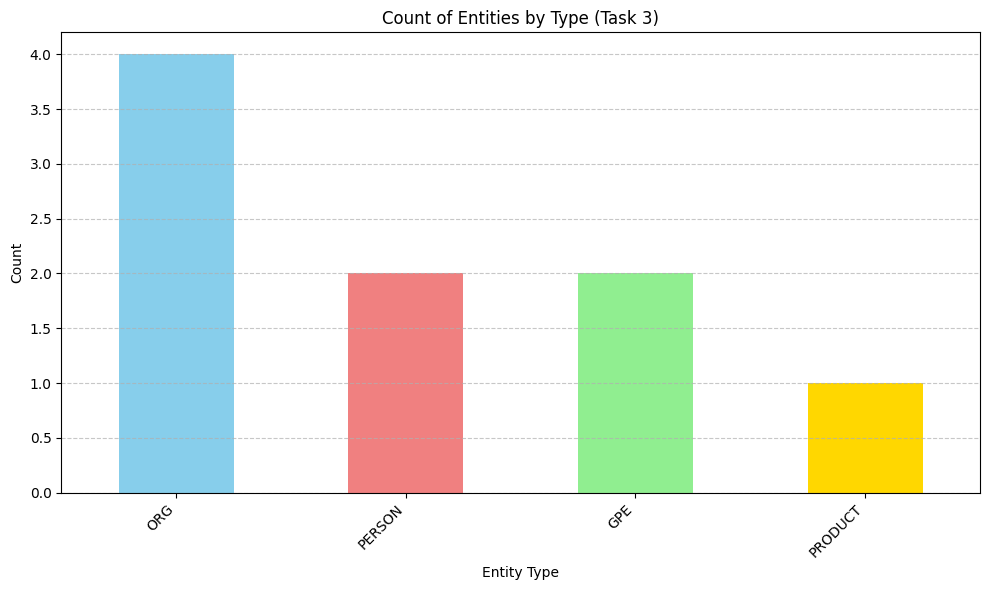

Bar chart visualizing entity counts displayed.


In [21]:
entity_counts = {label: len(entities) for label, entities in ent_dict.items()}
df_counts = pd.Series(entity_counts)

plt.figure(figsize=(10, 6))
df_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Count of Entities by Type (Task 3)')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar chart visualizing entity counts displayed.")

**ZAKLJUČAK ZA ZADATAK 3:**

Preciznost NER-a: spaCy model en_core_web_sm pokazao je dobru preciznost u prepoznavanju standardnih entiteta poput 'ORG', 'PERSON' i 'GPE', uz uspješno ručno dodavanje 'ChatGPT' kao 'PRODUCT' entiteta. Ipak, istaknuta je potreba za ručnom anotacijom ili finim podešavanjem za domenski specifične entitete.

Korisnost vizualizacije: Bar grafikon je pružio jasan pregled distribucije različitih tipova entiteta, što je korisno za brzo razumijevanje podataka, validaciju, izvještavanje i usmjeravanje daljnje analize. Kombinacija predefiniranih modela, mogućnosti dodavanja prilagođenih entiteta i vizualizacije nudi snažan alat za ekstrakciju i razumijevanje strukturiranih informacija iz nestrukturiranog teksta.

# **Zadatak 4**: Fine-Tuning NER Modela za Prepoznavanje Životinja



In [26]:
import spacy
from spacy.training import Example
from spacy import displacy
import random

# 1. Training data – ANIMAL entities
TRAIN_DATA = [
    ("The cat sat on the mat.", {"entities": [(4, 7, "ANIMAL")]}),
    ("A dog barked loudly in the street.", {"entities": [(2, 5, "ANIMAL")]}),
    ("I saw an elephant at the zoo.", {"entities": [(8, 16, "ANIMAL")]}),
    ("The tiger was sleeping under a tree.", {"entities": [(4, 9, "ANIMAL")]}),
    ("A small dog chased the cat.", {"entities": [(8, 11, "ANIMAL"), (22, 25, "ANIMAL")]}),
]

TEST_SENTENCE = "The dog chased the cat near my house."

nlp = spacy.load("en_core_web_md")

# Get the 'ner' pipe and add the new label
ner = nlp.get_pipe("ner")
if "ANIMAL" not in ner.labels:
    ner.add_label("ANIMAL")

print("=== BEFORE TRAINING ===")
doc_before = nlp(TEST_SENTENCE)
for ent in doc_before.ents:
    print(ent.text, ent.label_)
displacy.render(doc_before, style="ent", jupyter=True, options={"colors": {"ANIMAL": "#ff6961"}})


=== BEFORE TRAINING ===


In [28]:
import spacy.cli
spacy.cli.download("en_core_web_md")
print("en_core_web_md model download initiated.")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
en_core_web_md model download initiated.


In [29]:
import spacy
from spacy.training import Example
from spacy import displacy
import random

# 1. Training data – ANIMAL entities
TRAIN_DATA = [
    ("The cat sat on the mat.", {"entities": [(4, 7, "ANIMAL")]}),
    ("A dog barked loudly in the street.", {"entities": [(2, 5, "ANIMAL")]}),
    ("I saw an elephant at the zoo.", {"entities": [(8, 16, "ANIMAL")]}),
    ("The tiger was sleeping under a tree.", {"entities": [(4, 9, "ANIMAL")]}),
    ("A small dog chased the cat.", {"entities": [(8, 11, "ANIMAL"), (22, 25, "ANIMAL")]}),
]

TEST_SENTENCE = "The dog chased the cat near my house."

nlp = spacy.load("en_core_web_md")

# Get the 'ner' pipe and add the new label
ner = nlp.get_pipe("ner")
if "ANIMAL" not in ner.labels:
    ner.add_label("ANIMAL")

# Disable other pipes during training to speed it up and avoid interference
other_pipes = [p for p in nlp.pipe_names if p != "ner"]
with nlp.disable_pipes(*other_pipes):
    # Initialize the optimizer for training
    optimizer = nlp.resume_training()

    print("\n=== TRAINING STARTED ===")
    # Train the model
    for epoch in range(30): # Number of iterations
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            # Create an Example object from text and annotations
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            # Update the model
            nlp.update([example], drop=0.5, sgd=optimizer, losses=losses)
        # print(f"Epoch {epoch + 1} Losses: {losses}") # Optional: print losses per epoch
    print("=== TRAINING FINISHED ===")

print("\n=== AFTER TRAINING ===")
doc_after = nlp(TEST_SENTENCE)
for ent in doc_after.ents:
    print(ent.text, ent.label_)
displacy.render(doc_after, style="ent", jupyter=True, options={"colors": {"ANIMAL": "#ff6961"}})


=== TRAINING STARTED ===


/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "A small dog chased the cat." with entities "[(8, 11, 'ANIMAL'), (22, 25, 'ANIMAL')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I saw an elephant at the zoo." with entities "[(8, 16, 'ANIMAL')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


=== TRAINING FINISHED ===

=== AFTER TRAINING ===
dog ANIMAL
cat ANIMAL


**ZAKLJUČAK za ZADATAK 3**

Fine-tuning NER modela za prepoznavanje životinja ima brojne stvarne primjene. U očuvanju divljih životinja i istraživanju, omogućuje automatiziranu identifikaciju vrsta i praćenje biološke raznolikosti analizom velikih količina teksta. U industriji kućnih ljubimaca i zaštiti životinja, pomaže u platformama za usvajanje, veterinarskoj medicini i otkrivanju zlouporabe životinja skeniranjem zapisa i društvenih medija. U poljoprivredi i prehrambenoj industriji, koristi se za upravljanje stokom i osiguravanje sljedivosti hrane. Također je koristan u moderiranju sadržaja i pronalaženju informacija, omogućujući filtriranje neprikladnog sadržaja i kategorizaciju medija fokusiranih na životinje.

**ZAKLJUČAK**

Ova vježba je demonstrirala različite aspekte Named Entity Recognition (NER) koristeći spaCy, pandas i matplotlib, naglašavajući njegovu svestranost u izvlačenju strukturiranih informacija iz nestrukturiranog teksta.

Zadatak 1: Ekstrakcija i tablica entiteta: Uspješno je proveden NER, a entiteti su prikazani u pandas DataFrameu, što je potvrdilo osnovnu sposobnost NER-a.

Zadatak 2: Filtriranje i vizualizacija specifičnih entiteta: Filtrirani su entiteti 'PERSON', 'ORG' i 'LOC', a displacy je učinkovito vizualizirao entitete, iako su uočene pogrešne klasifikacije (npr. 'Reynolds' kao 'ORG'), što ukazuje na potrebu za prilagodbom.

Zadatak 3: Dodavanje prilagođenih entiteta i vizualizacija: Ručno je dodan 'ChatGPT' kao 'PRODUCT' entitet, a bar grafikon je pružio brzi uvid u sastav teksta po tipovima entiteta.

Zadatak 4: Fine-tuning NER modela za 'ANIMAL' entitet: Uspješno je fine-tuniran model en_core_web_md za prepoznavanje 'ANIMAL' entiteta koristeći mali prilagođeni skup podataka. To je pokazalo moć transfer learninga i vrijednost specijaliziranih NER modela u područjima poput zaštite divljih životinja, brige o kućnim ljubimcima, poljoprivrede i moderiranja sadržaja.

Zaključak: NER je temeljna NLP tehnika za pretvaranje nestrukturiranog teksta u strukturirane podatke. Vježba je pokazala jednostavnost korištenja spaCy-ja, fleksibilnost (filtriranje, dodavanje prilagođenih entiteta, fine-tuning) i važnost vizualizacije. Iako predefinirani modeli pružaju dobar temelj, prilagodba je ključna za visoku točnost u specifičnim kontekstima. U konačnici, NER je moćan alat čiju učinkovitost dodatno poboljšavaju strateško filtriranje, definiranje prilagođenih entiteta i ciljano fine-tuning.